<a href="https://colab.research.google.com/github/mtyt/optime/blob/main/examples/Recipes_for_the_planet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Our World In Data: Environmental Impacts of Food Production
[Our World In Data](https://ourworldindata.org) published an article that shows how what we eat impacts the environment. For a number of foods - about 200 - they collected the CO2 emissions, land use, water use, [eutrophication](https://en.wikipedia.org/wiki/Eutrophication) per kg but also per 100 g of protein, 100 g of fat and per 1000 kcal. This way, they created some interesting graphs which yield insights into which foods are better for the planet, and which are very bad ([BEEF!](https://ourworldindata.org/explorers/food-footprints?facet=none&hideControls=false&Commodity+or+Specific+Food+Product=Commodity&Environmental+Impact=Carbon+footprint&Kilogram+%2F+Protein+%2F+Calories=Per+kilogram&By+stage+of+supply+chain=false&country=Bananas~Beef+%28beef+herd%29~Beef+%28dairy+herd%29~Cheese~Eggs~Lamb+%26+Mutton~Milk~Maize~Nuts~Pig+Meat~Peas~Potatoes~Poultry+Meat~Rice~Tomatoes~Wheat+%26+Rye~Tofu+%28soybeans%29~Prawns+%28farmed%29)).

However, this isn't a very practical way of deciding what you will eat for dinner tonight! You can think: "oh perhaps I will have some beer and some peas!" and then look up the environmental impact. But how many kilograms of beer and peas will you need for a healthy diet?
That's where this Notebook comes in.
It aims to solve the problem: I want to consume just enough food to satisfy my nutritional needs (kcal, fat and protein) at the lowest environmental impact possible, what should I eat?

In order to solve this question, I'm using a [genetic algorithm (GA)](https://en.wikipedia.org/wiki/Genetic_algorithm), which I implemented in a Python package, available on GitHub, called [`optime`](https://github.com/mtyt/optime), to optimize your diet towards minimal environmetal impact, while satisfying your healthy nutritional needs!

- [First](#one-food), I will take a simplified case where you're going to eat only 1 type of food every day. Which food should it be to consume enough calories, fat and protein, while having the minimum environmental impact possible?

- [Second](#all-food), we will use the power of all of the foods and combine them to find the ultimate recipe that satisfies our hunger while minimizing environmental impact!


## How to use:
If you are not familiar with Python, Jupyter Notebooks and/or Google Colab: no worries! You don't need to understand the code to execute it. Just hit the play-button on the left of each cell or hit shift-enter or click Runtime > Run all. If you're still having problems, don't hesitate to contact me for help.

The first time running this Notebook after opening, it might take a while to install some dependencies. Please be patient!

## Sources:
- [Our World In Data: Environmental Impacts of Food Production](https://ourworldindata.org/environmental-impacts-of-food):
Hannah Ritchie and Max Roser (2022) - "Environmental Impacts of Food Production". Published online at OurWorldInData.org.
- Optime: a simple optimizer package, available on [GitHub](https://github.com/mtyt/optime)


## Disclaimer
Unfortunately, the data available on the website of OWID does not mention any sugar contents in any of the foods, so it's perfectly possible that the diets I'm proposing are actually life-threatening. So please don't use this Notebook as actual dietary advice!
Also, I didn't look at cost.
But, provide me the data and I'll add it to the equation!

## About
This notebook was made by Maarten Tytgat (maarten.tytgat@gmail.com), who has a website: www.futiledevices.be

In [1]:
# At every new Runtime, we unfortunately have to install some things. Don't worry,
# this doesn't put anything on your computer, it's all in the cloud.
!pip install --upgrade pip # some older versions of pip have trouble with installing from github
!pip install 'optime @ git+https://github.com/mtyt/optime@8439669e9028419082028c2c363bb264892dc9ff'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/mtyt/optime (to revision 8439669e9028419082028c2c363bb264892dc9ff) to /tmp/pip-install-idz7tuh9/optime_43154d88df454e10adeed71eabce03fb
  Running command git clone --filter=blob:none --quiet https://github.com/mtyt/optime /tmp/pip-install-idz7tuh9/optime_43154d88df454e10adeed71eabce03fb
  Running command git rev-parse -q --verify 'sha^8439669e9028419082028c2c363bb264892dc9ff'
  Running command git fetch -q https://github.com/mtyt/optime 8439669e9028419082028c2c363bb264892dc9ff
  Running command git checkout -q 8439669e9028419082028c2c363bb264892

In [2]:
# Some standard python stuff:
from functools import partial
import pandas as pd
import re
import numpy as np
from functools import cached_property
import matplotlib.pyplot as plt
from optime.ga import Population, child

In [3]:
# Loading the data and printing the first few lines.
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1B68Sg_OQblBxJkmqP3lLXSJ2C23tFEJy")
df = df.set_index('Entity')
df[0:9]

,Emissions per kilogram,Emissions per 1000 kilocalories,Emissions per 100 grams of protein,Emissions per 100 grams of fat,Land use per kilogram,Land use per 1000 kilocalories,Land use per 100 grams of protein,Land use per 100 grams of fat,Eutrophication per kilogram,Eutrophication per 1000 kilocalories,...,Water scarcity per 100 grams of fat,Water withdrawals per kilogram,Water withdrawals per 1000 kilocalories,Water withdrawals per 100 grams of protein,Water withdrawals per 100 grams of fat,Year,biodiversity_kg,biodiversity_1000kcal,biodiversity_100gprotein,biodiversity_100gfat
Entity,,,,,,,,,,,,,,,,,,,,,
Ale,0.488690,0.317338,0.878525,2.424209,0.811485,0.601152,1.577687,3.065766,1.633120,1.156801,...,7.464549e+03,49.402842,37.873277,98.984968,181.803039,2022,19.944790,15.570546,39.861995,62.666331
Almond butter,0.387011,0.067265,0.207599,0.079103,7.683045,1.296870,3.608433,1.495297,18.723075,3.165000,...,7.771497e+04,6846.472597,1151.953867,3125.971106,1324.701109,2022,252.788221,42.626235,117.246387,49.101614
Almond milk,0.655888,2.222230,13.595512,4.057470,1.370106,2.675063,12.687839,4.600530,4.148876,9.317069,...,4.311180e+05,1246.973783,2766.258122,13432.324330,4286.672872,2022,50.401108,99.766367,477.142139,190.732797
Almonds,0.602368,0.105029,0.328335,0.119361,8.230927,1.423376,4.261040,1.610136,18.595755,3.211890,...,7.290820e+04,6413.314597,1106.064215,3258.085733,1254.124113,2022,261.718501,45.213038,134.399913,51.438593
Apple juice,0.458378,0.955184,29.152212,19.754979,0.660629,1.382839,43.232158,26.246743,1.911657,3.796368,...,1.991183e+05,122.318340,245.723809,6160.521065,8566.814616,2022,11.021176,22.752032,668.427016,551.574374
Apple pie,1.244974,0.418182,4.704171,2.585492,1.765165,0.597374,6.471804,3.819800,6.619580,2.097777,...,1.529131e+04,396.387449,123.509329,1332.983066,654.048409,2022,48.437330,17.764296,176.288395,88.504053
Apples,0.507354,0.898188,13.442716,25.594410,0.668999,1.205081,18.667990,36.386277,1.205580,2.048058,...,1.330595e+05,90.334227,157.488796,2530.714498,4607.391166,2022,10.900282,18.706499,294.470101,553.163642
Apricot jam,1.382105,0.761620,24.972615,56.586200,1.368510,0.769479,24.387252,60.947300,11.446767,6.730958,...,1.129829e+06,851.048765,492.296127,14911.832672,38160.831188,2022,46.484368,26.154165,828.895012,2091.749372
Asparagus,0.925692,2.791229,3.853152,16.707521,1.401769,3.909719,5.424797,20.964724,4.001620,11.004208,...,4.190409e+05,310.514263,966.892671,1299.857704,5221.708745,2022,22.555139,65.941056,90.994481,327.676583


Just to show what types of food are included in this list (some of them are questionable, to say the least, like what is "haddock risotto"?):

In [4]:
print(df.index.values)

['Ale' 'Almond butter' 'Almond milk' 'Almonds' 'Apple juice' 'Apple pie'
 'Apples' 'Apricot jam' 'Asparagus' 'Avocados' 'Bacon' 'Bagels' 'Baguette'
 'Banana loaf' 'Bananas' 'Beans' 'Beef burger' 'Beef curry'
 'Beef meatballs' 'Beef mince' 'Beef noodles' 'Beef steak' 'Beer'
 'Beetroot' 'Biscuits' 'Blue cheese' 'Brazil nuts' 'Bread'
 'Breakfast cereal' 'Brie' 'Broccoli' 'Butter' 'Cabbage' 'Caesar salad'
 'Camembert' 'Carrot cake' 'Carrots' 'Cashew nuts' 'Cauliflower'
 'Cereal bars' 'Cheddar cheese' 'Cheesecake' 'Cherry tomatoes'
 'Chia seeds' 'Chicken breast' 'Chicken burger' 'Chicken curry'
 'Chicken noodles' 'Chicken pasta' 'Chicken sausages' 'Chicken thighs'
 'Chicken wings' 'Chickpeas' 'Chilli con carne' 'Chocolate biscuits'
 'Chocolate cake' 'Chocolate cereals' 'Chocolate cheesecake'
 'Chocolate spread' 'Cider' 'Coconut milk' 'Coconut oil' 'Cod'
 'Cod fish fingers' 'Cod fishcakes' 'Coffee beans' 'Coffee pods' 'Cookies'
 'Cottage cheese' 'Cottage pie' 'Courgettes' 'Couscous' "Cow's m

# What should I eat to keep myself and the planet alive?
According to some sources, a person needs 2500 kcal, 72g fat and 50g protein a day. If you think this is different for you, please go ahead and change the numbers before executing the cell (and the next cells).
Again, note how the program does not care about your sugar intake!

In [5]:
target_kcal = 2500
target_fat = 72
target_protein = 50

The original data only mentions the environmental impact (emissions, land use etc) per kg or kcal etc of food, but not the kcal/kg or fat/kg etc. Those can be obtained by dividing one number by the other. But I noticed that the results differ slightly depending on which criterium (Emissions, Land use, Eutrophication or Water withdrawals) I use.


Different impact criteria yield different amount of nutrients per kg. Let's for example look at protein content for Ale:

In [6]:
food = 'Ale'
prot_1 = 100/df.at[food,'Emissions per 100 grams of protein']*df.at[food,'Emissions per kilogram']
prot_2 = 100/df.at[food,'Eutrophication per 100 grams of protein']*df.at[food, 'Eutrophication per kilogram']
print(f'grams of protein per kg of {food} based on Emissions = {prot_1}')
print(f'grams of protein per kg of {food} based on Eutrophication = {prot_2}')

grams of protein per kg of Ale based on Emissions = 55.626201231013304
grams of protein per kg of Ale based on Eutrophication = 52.855536838206234


So, I will take the average of the nutrient per kg as given by each of the criteria and use that from now on:

In [7]:
criteria = ['Emissions', 'Land use', 'Eutrophication', 'Water withdrawals']
nutrients = ['1000 kilocalories', '100 grams of protein', '100 grams of fat']

new_cols = []
for nut in nutrients:
  for crit in criteria:
    new_col = nut + '/kg based on ' + crit
    new_cols.append(new_col)
    df[new_col] = df[crit + ' per kilogram'] / df[crit + ' per ' + nut]
  df[nut + '/kg'] = df[[(nut + '/kg based on ' + crit) for crit in criteria]].mean(axis='columns')
print("Showing the new columns only, with the nutrients per kg based on the different criteria:")
df[new_cols][0:9]

Showing the new columns only, with the nutrients per kg based on the different criteria:


,1000 kilocalories/kg based on Emissions,1000 kilocalories/kg based on Land use,1000 kilocalories/kg based on Eutrophication,1000 kilocalories/kg based on Water withdrawals,100 grams of protein/kg based on Emissions,100 grams of protein/kg based on Land use,100 grams of protein/kg based on Eutrophication,100 grams of protein/kg based on Water withdrawals,100 grams of fat/kg based on Emissions,100 grams of fat/kg based on Land use,100 grams of fat/kg based on Eutrophication,100 grams of fat/kg based on Water withdrawals
Entity,,,,,,,,,,,,
Ale,1.539967,1.349883,1.411755,1.304425,0.556262,0.514351,0.528555,0.499094,0.201587,0.264692,0.237961,0.271738
Almond butter,5.753550,5.924299,5.915663,5.943357,1.864222,2.129191,2.138729,2.190191,4.892484,5.138141,5.127835,5.168315
Almond milk,0.295148,0.512177,0.445298,0.450780,0.048243,0.107986,0.093783,0.092834,0.161649,0.297815,0.234911,0.290895
Almonds,5.735273,5.782680,5.789661,5.798320,1.834614,1.931671,1.949712,1.968430,5.046587,5.111944,5.109434,5.113780
Apple juice,0.479885,0.477734,0.503549,0.497788,0.015724,0.015281,0.022146,0.019855,0.023203,0.025170,0.012950,0.014278
Apple pie,2.977111,2.954873,3.155522,3.209373,0.264653,0.272747,0.292313,0.297369,0.481523,0.462109,0.603222,0.606052
Apples,0.564864,0.555148,0.588645,0.573591,0.037742,0.035837,0.037430,0.035695,0.019823,0.018386,0.020319,0.019606
Apricot jam,1.814692,1.778489,1.700615,1.728733,0.055345,0.056116,0.057155,0.057072,0.024425,0.022454,0.022823,0.022302
Asparagus,0.331643,0.358535,0.363645,0.321147,0.240243,0.258400,0.253560,0.238883,0.055406,0.066863,0.054859,0.059466


In [8]:
print("Showing the new columns of the average nutrients per kg:")
df[[nut + '/kg' for nut in nutrients]][0:9]

Showing the new columns of the average nutrients per kg:


,1000 kilocalories/kg,100 grams of protein/kg,100 grams of fat/kg
Entity,,,
Ale,1.401507,0.524566,0.243995
Almond butter,5.884217,2.080583,5.081694
Almond milk,0.425851,0.085711,0.246318
Almonds,5.776484,1.921107,5.095436
Apple juice,0.489739,0.018251,0.018900
Apple pie,3.074220,0.281770,0.538226
Apples,0.570562,0.036676,0.019534
Apricot jam,1.755632,0.056422,0.023001
Asparagus,0.343742,0.247772,0.059148


In [9]:
# Now we don't need those new columns anymore and we'll just the average from now on.
# Let's also remove some columns we won't use.
remove_cols = new_cols + [
    'Year',
       'biodiversity_kg', 'biodiversity_1000kcal', 'biodiversity_100gprotein',
       'biodiversity_100gfat'
]
df = df.drop(columns=remove_cols)
df[0:9]

,Emissions per kilogram,Emissions per 1000 kilocalories,Emissions per 100 grams of protein,Emissions per 100 grams of fat,Land use per kilogram,Land use per 1000 kilocalories,Land use per 100 grams of protein,Land use per 100 grams of fat,Eutrophication per kilogram,Eutrophication per 1000 kilocalories,...,Water scarcity per 1000 kilocalories,Water scarcity per 100 grams of protein,Water scarcity per 100 grams of fat,Water withdrawals per kilogram,Water withdrawals per 1000 kilocalories,Water withdrawals per 100 grams of protein,Water withdrawals per 100 grams of fat,1000 kilocalories/kg,100 grams of protein/kg,100 grams of fat/kg
Entity,,,,,,,,,,,,,,,,,,,,,
Ale,0.488690,0.317338,0.878525,2.424209,0.811485,0.601152,1.577687,3.065766,1.633120,1.156801,...,1417.812822,3.746103e+03,7.464549e+03,49.402842,37.873277,98.984968,181.803039,1.401507,0.524566,0.243995
Almond butter,0.387011,0.067265,0.207599,0.079103,7.683045,1.296870,3.608433,1.495297,18.723075,3.165000,...,67620.142757,1.827076e+05,7.771497e+04,6846.472597,1151.953867,3125.971106,1324.701109,5.884217,2.080583,5.081694
Almond milk,0.655888,2.222230,13.595512,4.057470,1.370106,2.675063,12.687839,4.600530,4.148876,9.317069,...,282550.644552,1.471679e+06,4.311180e+05,1246.973783,2766.258122,13432.324330,4286.672872,0.425851,0.085711,0.246318
Almonds,0.602368,0.105029,0.328335,0.119361,8.230927,1.423376,4.261040,1.610136,18.595755,3.211890,...,64275.149549,1.889947e+05,7.290820e+04,6413.314597,1106.064215,3258.085733,1254.124113,5.776484,1.921107,5.095436
Apple juice,0.458378,0.955184,29.152212,19.754979,0.660629,1.382839,43.232158,26.246743,1.911657,3.796368,...,6754.678597,1.777600e+05,1.991183e+05,122.318340,245.723809,6160.521065,8566.814616,0.489739,0.018251,0.018900
Apple pie,1.244974,0.418182,4.704171,2.585492,1.765165,0.597374,6.471804,3.819800,6.619580,2.097777,...,2607.806727,2.830632e+04,1.529131e+04,396.387449,123.509329,1332.983066,654.048409,3.074220,0.281770,0.538226
Apples,0.507354,0.898188,13.442716,25.594410,0.668999,1.205081,18.667990,36.386277,1.205580,2.048058,...,4439.593463,6.840861e+04,1.330595e+05,90.334227,157.488796,2530.714498,4607.391166,0.570562,0.036676,0.019534
Apricot jam,1.382105,0.761620,24.972615,56.586200,1.368510,0.769479,24.387252,60.947300,11.446767,6.730958,...,14578.838901,4.124210e+05,1.129829e+06,851.048765,492.296127,14911.832672,38160.831188,1.755632,0.056422,0.023001
Asparagus,0.925692,2.791229,3.853152,16.707521,1.401769,3.909719,5.424797,20.964724,4.001620,11.004208,...,81275.701242,1.082534e+05,4.190409e+05,310.514263,966.892671,1299.857704,5221.708745,0.343742,0.247772,0.059148


# Preparation: define a recipe as a vector of kilograms per food
Take a random vector of food masses and calculate the total nutritional value and environment impact. We'll re-use this function later on.
The table shows for every food how many kilograms we have, and what is the nutritional value and environmental impact of that amount of food.

In [10]:
kg_vec = np.random.uniform(0,1,len(df)) # every food can have 0-1kg - no one said this was going to be a realistic example

def df_recipe(kg_vec):
    # copy the df and keep only the food names and nutrients and criteria, add a column for the kg vector,
    # then calculate the total nutrients and env impact based on the kg value:
    df_case = df[[nut + '/kg' for nut in nutrients]+[crit + ' per kilogram' for crit in criteria]].copy()
    df_case['kg'] = kg_vec.tolist()
    df_case['kcal'] = df_case['1000 kilocalories/kg']*df_case['kg']*1000
    df_case['g protein'] = df_case['100 grams of protein/kg']*df_case['kg']*100
    df_case['g fat'] = df_case['100 grams of fat/kg']*df_case['kg']*100

    for crit in criteria:
        df_case[crit] = df_case[crit + ' per kilogram']*df_case['kg']

    # clean up the df, to contain only the data we want to see:
    df_clean = df_case[['kg', 'kcal', 'g protein', 'g fat'] + criteria].copy()

    return df_clean

df_clean = df_recipe(kg_vec)
df_clean[0:9]

,kg,kcal,g protein,g fat,Emissions,Land use,Eutrophication,Water withdrawals
Entity,,,,,,,,
Ale,0.254155,356.199526,13.332078,6.201238,0.124203,0.206243,0.415065,12.555959
Almond butter,0.145341,855.220040,30.239476,73.858021,0.056249,1.116664,2.721237,995.075548
Almond milk,0.329464,140.302401,2.823881,8.115267,0.216091,0.451400,1.366904,410.832511
Almonds,0.784809,4533.438575,150.770264,399.894612,0.472744,6.459709,14.594123,5033.229498
Apple juice,0.191548,93.808475,0.349602,0.362033,0.087801,0.126542,0.366174,23.429820
Apple pie,0.227352,698.930062,6.406106,12.236687,0.283047,0.401314,1.504975,90.119486
Apples,0.379399,216.470624,1.391477,0.741099,0.192489,0.253817,0.457395,34.272695
Apricot jam,0.190119,333.778747,1.072686,0.437287,0.262764,0.260180,2.176246,161.800384
Asparagus,0.100176,34.434851,2.482086,0.592528,0.092732,0.140424,0.400868,31.106198


By summing the values in the columns, we can quickly see the total nutritional value and environmental impact if we were to eat the whole table.

In [11]:
df_clean.sum()

kg                      101.812500
kcal                 230671.830773
g protein              7723.485212
g fat                 10990.488206
Emissions               725.491913
Land use               1372.811782
Eutrophication         3158.092081
Water withdrawals     77138.036289
dtype: float64

<a name="one-food"></a>
# Case 1: You can only eat 1 type of food a day
For any food, how many kg do you need in order to have enough, and what is the environmental impact?
The only condition is that each nutrient is consumed at least as much as the recommended daily dose:
- target_kcal = 2500
- target_fat = 72
- target_protein = 50

(Or whatever you changed the numbers to)

So we determine the amount of kg for each food based on this procedure:
Calculate the kg you'd need to meet the target for each nutrient separately, then take the maximum. Note that the resulting table is not a list of everything we should eat in 1 day, but a list of how much we should eat of each food if we only ate that food that day!

In [12]:
df_case_1_food = df.copy()
# calculate an amount of kg you would need of the food to guarantee the recommended intake of kcal, protein and fat:
df_case_1_food['mult_kcal'] = target_kcal/df_case_1_food['1000 kilocalories/kg']/1000
df_case_1_food['mult_protein'] = target_protein/df_case_1_food['100 grams of protein/kg']/100
df_case_1_food['mult_fat'] = target_fat/df_case_1_food['100 grams of fat/kg']/100
# Take the max of the above 3 multipliers to ensure enough intake!
kg_vec = df_case_1_food[['mult_kcal', 'mult_protein', 'mult_fat']].max(axis='columns')
df_case_1_food['kg'] = kg_vec
df_clean = df_recipe(kg_vec)
print("The resulting DataFrame shows how much of each food (only that food) to eat daily, and the\
 resulting nutrients and environmental impact:")
df_clean

The resulting DataFrame shows how much of each food (only that food) to eat daily, and the resulting nutrients and environmental impact:


,kg,kcal,g protein,g fat,Emissions,Land use,Eutrophication,Water withdrawals
Entity,,,,,,,,
Ale,2.950884,4135.685051,154.793234,72.000000,1.442067,2.394598,4.819146,145.782037
Almond butter,0.424865,2500.000000,88.396772,215.903561,0.164428,3.264260,7.954786,2908.829019
Almond milk,5.870599,2500.000000,50.317757,144.603140,3.850452,8.043342,24.356383,7320.482562
Almonds,0.432789,2500.000000,83.143436,220.524997,0.260698,3.562257,8.048043,2775.613596
Apple juice,38.094423,18656.325532,69.527702,72.000000,17.461661,25.166298,72.823486,4659.646600
...,...,...,...,...,...,...,...,...
Vegetarian pizza,0.920699,2500.000000,123.665957,117.872586,4.817996,6.003633,18.463352,533.317863
Walnuts,0.410614,2500.000000,61.399729,224.354762,0.992169,4.876385,7.696121,1419.931178
Watermelon,16.265135,6238.007698,94.847463,72.000000,15.767467,16.425810,213.441131,12090.094003


Note that thanks to its high fat contents, you'd only need to drink about 3 liters of beer to get your minimum requirements, versus more than 70 liters of wine!

Since we restrict ourselves to only 1 food, there's not much flexibility in terms of balancing your calories, fat and protein intake. Neither is there any way to adjust the relative contributions to Emissions, Land use, Eutrophication and Water withdrawels.

However, we can sort the results by one of the criteria in order to see which food we should eat (and only that food) to minimize our impact there:

In [13]:
crit = 'Emissions'
print(f"The DataFrame sorted by {crit}:")
df_clean.sort_values(crit)

The DataFrame sorted by Emissions:


,kg,kcal,g protein,g fat,Emissions,Land use,Eutrophication,Water withdrawals
Entity,,,,,,,,
Almond butter,0.424865,2500.000000,88.396772,215.903561,0.164428,3.264260,7.954786,2908.829019
Almonds,0.432789,2500.000000,83.143436,220.524997,0.260698,3.562257,8.048043,2775.613596
Pumpkin seeds,0.608985,2500.000000,145.239862,172.122425,0.806282,2.031911,3.476828,129.473590
Sunflower seeds,0.418495,2500.000000,88.960698,213.197851,0.809547,4.594973,20.688123,5.969396
Chia seeds,0.699215,2500.000000,136.346855,185.991095,0.853429,2.396703,4.191638,147.466847
...,...,...,...,...,...,...,...,...
Prawns,11.091717,9226.887932,1724.288020,72.000000,231.942029,11.282105,1716.630042,35461.925627
Coffee pods,13.774060,2500.000000,157.045543,88.772504,279.610169,189.687853,1057.727286,2748.604130
Coffee beans,18.406959,2500.000000,446.855161,75.082062,309.689877,356.947088,1204.567650,298.439861


Turns out it's Almond butter for lowest Emissions! And you only need about 420 grams of it to get 2500 kcal. Cheap! Unsuprisingly, Almonds come in close second. Actually you might wonder what the difference is. Anyhow. Let's also print the best foods in terms of other impact factors:

In [14]:
for crit in criteria:
  row = df_clean.sort_values(crit).iloc[0]
  print(f"You only have to eat {row['kg']:.2} kg of {row.name} to get {row['kcal']:.1f} kcal, {row['g protein']:.2f} g protein, {row['g fat']:.2f} g fat, for miminum {crit}.")

You only have to eat 0.42 kg of Almond butter to get 2500.0 kcal, 88.40 g protein, 215.90 g fat, for miminum Emissions.
You only have to eat 1.4 kg of Potato croquettes to get 3057.2 kcal, 50.00 g protein, 153.89 g fat, for miminum Land use.
You only have to eat 0.61 kg of Pumpkin seeds to get 2500.0 kcal, 145.24 g protein, 172.12 g fat, for miminum Eutrophication.
You only have to eat 5.3 kg of Beans to get 8087.6 kcal, 761.03 g protein, 72.00 g fat, for miminum Water withdrawals.


So that's interesting: Almonds, potato croquettes, pumkin seeds and beans are pretty good for the environment. But, we have different optima for different impact criteria. Moreover, by eating only almond butter, you will eat a bit too much protein and too much fat! Surely we can do better by applying the art of throwing together a bunch of different ingredients!

<a name="all-food"></a>
# Case 2: Optimize the food vector
Can we find the ultimate food combination that satisfies our hunger and minizes environmental impact?

Since I'm not an expert on environmental sciences, if that is even a thing, I don't know what the relative importance of these four criteria is. So I'm going to say they are completely independent and equally important. That means I have to do a multi-objective optimization. This can be done by looking at the [Pareto front](https://en.wikipedia.org/wiki/Pareto_front). 

When we compare a number of food-vectors (recipes), we have to decide which are better than others. Here, the concept of "non-dominated invividuals" comes in. Our recipes are the individuals that we want to compare. And a recipe is non-dominated when it is at least the best on 1 criterium and not worse on the others. Then the Pareto-front of the population is the collection of those non-dominated individuals. Then in the Genetic Algorithm, by introducing new individuals through mating and mutation, we can select in each generation the best individuals and continue with those.

On top of optimizing for low environmental impact (those 4 criteria), we will aim for nutritional value as close to the targets of the 3 components (kcal, fat, protein) as possible. In the code below, we define the `nutrient_score` as a sum of relative differences to the target for each component. So we want this difference to be as small as possible. Additionally, we add a hard condition that each component needs to be higher than the target (we don't want to starve) - the `enough` property.

Note that we could also optimize for low impact and high nutritional
  value but those inherently conflict with each other. Increasing the total kg
  value of a food vector will always increase its nutritional value but also
  its environmental impact. Here, we're only interested in getting *just enough*
  nutrition.

### Let's first make a class to define the food vector and its scores. Let's call it... Recipe!

In [15]:
def col_to_var(col):
    """Function to turn a DataFrame column name into a variable name, replacing
    capitals by lowercase and spaces by underscores.
    """
    return re.sub('\W|^(?=\d)','_', col).lower()
criteria_vars = [col_to_var(col) for col in criteria]

# Little helper function to set smallest elements to 0:
def keep_k_largest(vec, k):
  """In the vector vec, keep the k largest numners, set others to 0.
  But vector keeps same length.
  """
  if not isinstance(vec, np.ndarray):
    vec = np.array(vec)
  small_ind = np.argpartition(vec, -k)[:-k]
  vec[small_ind] = 0
  return vec

class Recipe():
    """ A Recipe will be the individual in the genetic algorithm. The best Recipe
    is the one that has the lowest environmental impact and just enough nutritional
    content.

    A Recipe can be initialized without any arguments, in which case it will be
    created with a random vector for kg values.
    """
    def __init__(self, kg_vec=None, max_ingredients=None):
        if kg_vec is None:
            if max_ingredients:
                vec_len = max_ingredients
            else:
                vec_len = len(df)
            kg_vec = np.zeros(len(df))
            # choose which indices will be assigned a value:
            choisi = np.random.choice(np.arange(len(kg_vec)), vec_len, replace=False)
            # I've manually finetuned the upper limit for kg_vec in order to get 
            # close to target nutrients for a random vector
            kg_vec[choisi] = np.random.uniform(0,0.02*len(df)/vec_len, vec_len)
        self.max_ingredients = max_ingredients
        self.kg_vec = kg_vec # use the setter

    @property
    def kg_vec(self):
        return self._kg_vec
    
    @kg_vec.setter
    def kg_vec(self, x):
        if self.max_ingredients:
            # set the smallest values to zero, keeping only max_ingredients
            x = keep_k_largest(x, self.max_ingredients)
        self._kg_vec = x
        # when the setter is called, these cached_property must be updated:
        list_of_dependent_properties = ['df',
                                        'summary',
                                        'impact',
                                        'nutrients',
                                        'enough',
                                        'not_enough'
                                        ]
        for prop in list_of_dependent_properties:
            if prop in  self.__dict__:
                delattr(self,prop)

    @cached_property
    def df(self):
      # re-use function from above and sort by kg:
      return df_recipe(self.kg_vec).sort_values('kg', ascending=False)
    
    @cached_property
    def summary(self):
        return self.df.sum()
    
    @cached_property
    def impact(self):
        return self.summary[criteria]
    
    def get_crit(self, crit):
        return self.impact[crit]
    
    # These lines will dynamically create a property attribute for each criterium in the df:
    for crit, crit_var in zip(criteria, criteria_vars):
        fget_crit = partial(get_crit, crit=crit)
        vars()[crit_var] = property(fget=fget_crit)
    
    @cached_property
    def nutrients(self):
        return self.summary[['kcal', 'g protein', 'g fat']]
    
    @cached_property
    def enough(self):
        return all([(self.summary['kcal'] > target_kcal),
                   (self.summary['g protein'] > target_protein),
                   (self.summary['g fat'] > target_fat)
                   ]
                  )
    @cached_property
    def not_enough(self):
        if self.enough:
            return 0
        else:
            return 1
        
    @cached_property
    def nutrient_score(self):
        """ The nutrient score is 1 measure to check how far off the Recipe is from
        the minimum requirements (target_kcal, target_protein, target_fat). It is
        calculated as the sum of the relative deltas. So a value of 0 would mean
        that each target is met.
        """
        scores = [0,0,0]
        scores[0] = (self.summary['kcal'] - target_kcal)/target_kcal
        scores[1] = (self.summary['g protein'] - target_protein)/target_protein
        scores[2] = (self.summary['g fat'] - target_fat)/target_fat
        return sum(scores)

    # The optime Population requires an attribute called "dna" to exist on the
    # class to be used as individuals in the Genetic Algorithm. For Recipe, this
    # is just the kg_vec attribute:
    dna = kg_vec

As an example, create a random Recipe with maximum 10 ingredients:

In [16]:
R1 = Recipe(max_ingredients=10)
R1.df[:12]

,kg,kcal,g protein,g fat,Emissions,Land use,Eutrophication,Water withdrawals
Entity,,,,,,,,
Strawberry jam,0.404675,779.415553,2.021884,0.668134,1.050805,1.201293,5.523541,384.320761
Brie,0.391347,1314.739990,70.593093,112.188958,7.490227,8.787468,25.152334,690.942988
Salmon,0.367475,646.838576,79.114099,28.665312,3.826362,1.744756,21.226523,500.014049
Tomato ketchup,0.361787,412.332822,5.981850,0.931763,0.944189,0.603375,3.731502,179.066572
Sourdough bread,0.342203,846.374198,23.242797,6.404994,0.291272,0.811679,1.853045,85.088773
Chilli con carne,0.269801,465.703424,20.653679,28.088861,3.653319,7.636624,51.000436,338.627724
Tortilla wraps,0.231510,544.846527,17.459528,12.830675,0.219606,0.522312,1.158290,53.672281
Mozzarella cheese,0.077403,186.042225,14.287432,13.386903,1.256494,1.475395,4.259603,116.673120
Spaghetti bolognese,0.040275,68.419997,2.448026,3.160566,0.315544,0.610560,3.893194,34.022958


Hmmm, that looks delicious!
Just stir it all together and add some salt and pepper, but not too much or
you'll mess with the environmental impact and nutritional value:

In [17]:
R1.summary

kg                      2.490875
kcal                 5278.629812
g protein             236.517165
g fat                 207.400363
Emissions              19.119451
Land use               23.477250
Eutrophication        118.042023
Water withdrawals    2389.159438
dtype: float64

## Then use `optime` to optimize it
Now, we make a number of random `Recipe`s and use it as a starting population for the genetic algorithm. You can play with the `max_ingredients` parameter to limit your shopping time (set it to `None` - no maximum - if you feel adventurous!). Numbers lower than 15 generally don't yield very good results though. You gotta put in the work to save the planet!

We define the goals for the optimization, basically minimize all the environmental impact + nutrient_score (defined as the sum of 
the relative differences to their targets - so 0 is perfectly on target!) and a hard condition: `enough == True`.

In [18]:
max_ingredients = 30

recipes = [Recipe(max_ingredients=max_ingredients) for _ in np.arange(20)]
pop = Population(recipes, goals_dict={
                                    'emissions':{'direction':'min','target':0},
                            'land_use':{'direction':'min','target':0},
                            'eutrophication':{'direction':'min','target':0},
                            'water_withdrawals':{'direction':'min','target':0},
                            'nutrient_score':{'direction':'min','target':0}
                                   },
                 conditions=['enough'])

Then, run the GA for a number of generations.
We can play with the number of generations (1st argument), the mutation probability (`mutprob`) - set this to a low number like 0.002 or something, because it is the probability of a mutation in the vector, and it has 200 values so you don't want too many ingredients to mutate incontrollably!
The `stop_on_steady_n` defines how many generations the mean and best values for each goal in the population must be constant before we decide it has converged.

Depending on the number of generations, this can run for a few minutes or more.

When the run is done, a plot is shown with the targets (0) and the mean and best values across the population for each goal (note that these don't occur within the same `Recipe` necessaririly) so we can check if there is convergence.
The 'best' line can be hidden under the 'target' line for the nutrient_score - which is a good thing!

Stop criteria met, stopping early.
Mean and best values for goals haven't changed for 5 generations


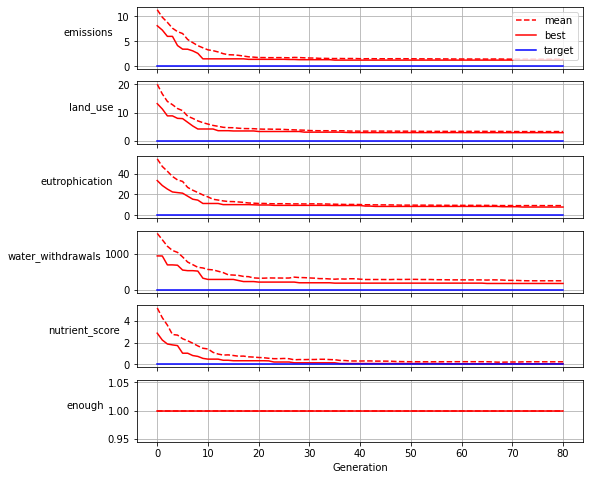

In [19]:
pop.run(100, mutprob=0.002, stop_on_steady_n=5, verbose=False)
pop.plot_progress()

Let's look at the Pareto Front after the optimization. According to the algorithm, these are the best Recipes at the moment, based on the 5 independent
optimization goals.

In [20]:
best_recipes = pop.pareto()
best_recipes

,Individual,emissions,land_use,eutrophication,water_withdrawals,nutrient_score,enough
0,<__main__.Recipe object at 0x7f4605a74730>,1.22606,3.354284,9.428175,186.592728,0.407062,True
1,<__main__.Recipe object at 0x7f4605ab4460>,1.470554,3.680626,9.723374,228.142447,0.086925,True
2,<__main__.Recipe object at 0x7f4605aae8b0>,1.378447,2.89275,9.722099,308.661378,0.234261,True
3,<__main__.Recipe object at 0x7f4605ad55e0>,1.366383,2.945555,9.137547,273.343901,0.246933,True
4,<__main__.Recipe object at 0x7f4605a9ee20>,1.355772,2.897657,9.156978,276.339613,0.238832,True
5,<__main__.Recipe object at 0x7f4605a56eb0>,1.426076,3.675352,9.177623,236.41477,0.057403,True
6,<__main__.Recipe object at 0x7f4605ac6b80>,1.47732,3.066098,9.547131,226.36903,0.351863,True
7,<__main__.Recipe object at 0x7f4605acfe80>,1.381985,2.872964,9.588307,272.269398,0.230397,True
8,<__main__.Recipe object at 0x7f4605b112e0>,1.301195,3.110517,8.699913,210.445207,0.285324,True
9,<__main__.Recipe object at 0x7f4605b116a0>,1.349084,3.524558,9.693052,177.423011,0.487944,True


We can arbitrarlity choose one of the Recipes above as the best, since they're all on the Pareto-front. So you can decide for yourself what you prioritize: being close to the nutrient targets (choose low `nutrient_score`) or lower emissions/land use/eutrophication/water withdrawals. Change the variable `priority` to any of the column names above to sort according to that metric:

In [25]:
priority = 'emissions'

chosen_recipes = {} # will contain the best recipe for each criterium
for prio in ['emissions', 'land_use', 'eutrophication', 'water_withdrawals']:
    chosen_recipe = best_recipes.sort_values(prio, ascending=True).iloc[0]['Individual']
    chosen_recipes[prio] = chosen_recipe

print('Best recipe for', priority)
chosen_recipes[priority].df[0:max_ingredients-1]

Best recipe for emissions


,kg,kcal,g protein,g fat,Emissions,Land use,Eutrophication,Water withdrawals
Entity,,,,,,,,
Falafels,0.137242,297.408482,10.830428,14.068588,0.150706,0.901338,1.689662,11.219699
Poppadoms,0.136109,653.289476,8.619815,33.662559,0.204248,0.674473,3.085517,39.958687
Croissants,0.115880,484.838235,6.144775,26.796959,0.194936,0.425285,1.111415,42.451061
Pancakes,0.109052,273.556413,6.139542,7.478015,0.168792,0.266246,0.853511,37.138794
Bagels,0.082544,201.442004,6.921988,1.791400,0.066267,0.186792,0.499786,24.049160
Frozen mashed potato,0.077478,73.515492,1.523377,2.162402,0.064046,0.096857,0.380935,3.513516
Rapeseed oil,0.074383,376.032475,7.219268,10.845791,0.244624,0.536618,1.142803,6.595703
Lemons,0.054552,23.050610,0.532929,0.138182,0.025648,0.033352,0.088205,6.724147
Frozen potato wedges,0.026433,36.499002,0.570497,0.407456,0.017572,0.044641,0.192493,0.916097


In [22]:
chosen_recipe.summary

kg                      0.866297
kcal                 2617.419427
g protein              50.942909
g fat                 102.392473
Emissions               1.349084
Land use                3.524558
Eutrophication          9.693052
Water withdrawals     177.423011
dtype: float64

Let's compare the top `Recipe`s based on each criterium and see of we can find some common ingredients there.

In [28]:
food_counter = []
top_ingredients_n = 7
for prio, recipe in chosen_recipes.items():
    print('\nBest Recipe for priority:', prio)
    print('Total values:')
    display(recipe.summary)
    print(f'Top {top_ingredients_n} ingredients (in kg):')
    food_counter = food_counter + list(recipe.df.index[:top_ingredients_n].values)
    print(recipe.df.index[:top_ingredients_n].values)


Best Recipe for priority: emissions
Total values:


kg                      0.860529
kcal                 2512.072756
g protein              50.866315
g fat                  99.713306
Emissions               1.226060
Land use                3.354284
Eutrophication          9.428175
Water withdrawals     186.592728
dtype: float64

Top 7 ingredients (in kg):
['Falafels' 'Poppadoms' 'Croissants' 'Pancakes' 'Bagels'
 'Frozen mashed potato' 'Rapeseed oil']

Best Recipe for priority: land_use
Total values:


kg                      1.036340
kcal                 2509.769289
g protein              50.713141
g fat                  87.280331
Emissions               1.381985
Land use                2.872964
Eutrophication          9.588307
Water withdrawals     272.269398
dtype: float64

Top 7 ingredients (in kg):
['Poppadoms' 'Cabbage' 'Croissants' 'Pancakes' 'Bagels'
 'Frozen mashed potato' 'Rapeseed oil']

Best Recipe for priority: eutrophication
Total values:


kg                      1.024162
kcal                 2506.102574
g protein              53.410143
g fat                  72.998140
Emissions               1.356466
Land use                3.220871
Eutrophication          7.960443
Water withdrawals     274.812231
dtype: float64

Top 7 ingredients (in kg):
['Apple pie' 'Falafels' 'Croissants' 'Oranges' 'Pancakes' 'Bagels'
 'Lemons']

Best Recipe for priority: water_withdrawals
Total values:


kg                      0.866297
kcal                 2617.419427
g protein              50.942909
g fat                 102.392473
Emissions               1.349084
Land use                3.524558
Eutrophication          9.693052
Water withdrawals     177.423011
dtype: float64

Top 7 ingredients (in kg):
['Falafels' 'Rapeseed oil' 'Poppadoms' 'Croissants' 'Pancakes' 'Lemons'
 'Frozen mashed potato']


Now we can count how many times each ingredient occurs in this hall of fame of recipes:

In [29]:
for food in set(food_counter):
    print(food, 'occurs ', food_counter.count(food), 'times')

Poppadoms occurs  3 times
Frozen mashed potato occurs  3 times
Falafels occurs  3 times
Bagels occurs  3 times
Pancakes occurs  4 times
Croissants occurs  4 times
Cabbage occurs  1 times
Lemons occurs  2 times
Oranges occurs  1 times
Apple pie occurs  1 times
Rapeseed oil occurs  3 times


So I don't know about you, but for me, high in the occurence list is ale, potatoes and pain au chocolat. Turns out I was doing right by the planet all along!

# Closing notes
I hope you had some fun with this. I certainly did. As I mentioned, don't take this as dietary advice. I ran this sheet numerous times to debug and experiment. At some point, I got croissants as onions as top ingredients and I was happy. But then I found a bug :'-(

So it's very likely that there are still mistakes and bugs in this sheet. If that's the case, please let me know! maarten.tytgat@gmail.com

What has been consistent though, is that meat never shows up in the top ingredients. I don't think that's a bug. I didn't see bugs either actually. Aren't they supposed to be the new meat?

Bon appétit!